# Draft Model

In [59]:
from bs4 import BeautifulSoup as BS
import pandas as pd
import requests

In [60]:
ADP_URL = "https://www.fantasypros.com/nfl/adp/ppr-overall.php"

In [61]:
def make_adp_df():
    res = requests.get(ADP_URL)
    if res.ok:
        soup = BS(res.content, 'html.parser')
        table = soup.find('table', {'id':'data'})
        df = pd.read_html(str(table))[0]
        print('Output after reading the html:\n\n',df.head(),'\n')
        df = df[['Player Team (Bye)','POS','AVG']]
        print('Output after filtering:\n\n',df.head(),'\n')
        df['PLAYER'] = df['Player Team (Bye)'].apply(lambda x:' '.join(x.split()[:-2]))
        df['POS'] = df['POS'].apply(lambda x:x[:2])
        
        df = df[['PLAYER','POS','AVG']].sort_values(by='AVG')
        
        print('Final output:\n\n', df.head())
        
        return df
    
    else:
        print("Didn't work, try again")

In [23]:
df = make_adp_df()

Output after reading the html:

    Rank             Player Team (Bye)  POS  ESPN  MFL  RTSports  Fantrax  AVG
0     1  Christian McCaffrey CAR (13)  RB1   1.0  NaN       1.0      1.0  1.0
1     2       Saquon Barkley NYG (11)  RB2   2.0  NaN       2.0      2.0  2.0
2     3      Ezekiel Elliott DAL (10)  RB3   3.0  NaN       3.0      4.0  3.3
3     4           Dalvin Cook MIN (7)  RB4   4.0  NaN       5.0      5.0  4.7
4     5         Michael Thomas NO (6)  WR1   6.0  NaN       6.0      3.0  5.0 

Output after filtering:

               Player Team (Bye)  POS  AVG
0  Christian McCaffrey CAR (13)  RB1  1.0
1       Saquon Barkley NYG (11)  RB2  2.0
2      Ezekiel Elliott DAL (10)  RB3  3.3
3           Dalvin Cook MIN (7)  RB4  4.7
4         Michael Thomas NO (6)  WR1  5.0 

Final output:

                 PLAYER POS  AVG
0  Christian McCaffrey  RB  1.0
1       Saquon Barkley  RB  2.0
2      Ezekiel Elliott  RB  3.3
3          Dalvin Cook  RB  4.7
4       Michael Thomas  WR  5.0


In [24]:
df.head()

,PLAYER,POS,AVG
0,Christian McCaffrey,RB,1.0
1,Saquon Barkley,RB,2.0
2,Ezekiel Elliott,RB,3.3
3,Dalvin Cook,RB,4.7
4,Michael Thomas,WR,5.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 0 to 1001
Data columns (total 3 columns):
PLAYER    1002 non-null object
POS       1002 non-null object
AVG       1002 non-null float64
dtypes: float64(1), object(2)
memory usage: 31.3+ KB


In [26]:
replacement_players = {
    'RB':None,
    'WR':None,
    'TE':None,
    'QB':None
}

In [27]:
replacement_players

{'RB': None, 'WR': None, 'TE': None, 'QB': None}

In [28]:
# look at the top 100 picks in our df and get the last RB, WR, QB, and TE
# and store them in our dict

for _, row in df[:100].iterrows():
    position = row['POS']
    player = row['PLAYER']
    replacement_players[position] = player
    
replacement_players

{'RB': 'Kerryon Johnson',
 'WR': 'John Brown',
 'TE': 'Jared Cook',
 'QB': 'Carson Wentz'}

Get projected player scores

In [32]:
BASE_URL = 'https://www.fantasypros.com/nfl/projections/{position}.php?week=draft'

def make_projection_df():
    
    final_df = pd.DataFrame()
    
    for position in ['rb', 'qb', 'te', 'wr']:
        
        res = requests.get(BASE_URL.format(position=position))
        if res.ok:
            soup = BS(res.content, 'html.parser')
            table = soup.find('table', {'id': 'data'})
            df = pd.read_html(str(table))[0]
            
            df.columns = df.columns.droplevel(level=0)
            df['PLAYER'] = df['Player'].apply(lambda x: ' '.join(x.split()[:-1]))
            if 'REC' in df.columns:
                df['FPTS'] = df['FPTS'] + df['REC']
                
            df['POS'] = position.upper()
            
            df = df[['PLAYER', 'POS', 'FPTS']]
            final_df = pd.concat([final_df, df])
            
        else:
            print("Didn't work, try again")
            return
    
    final_df = final_df.sort_values(by='FPTS', ascending=False)
    
    return final_df

In [33]:
df = make_projection_df()
df.head()

,PLAYER,POS,FPTS
0,Christian McCaffrey,RB,366.5
0,Lamar Jackson,QB,355.3
1,Patrick Mahomes,QB,342.0
0,Michael Thomas,WR,326.3
2,Dak Prescott,QB,313.7


Calculate replacement values

In [34]:
replacement_values = {
    'RB':None,
    'WR':None,
    'TE':None,
    'QB':None
}

replacement_values

{'RB': None, 'WR': None, 'TE': None, 'QB': None}

In [36]:
for position, player in replacement_players.items():
    if position in ['QB','TE', 'WR', 'RB']:
        replacement_values[position] = df.loc[df['PLAYER'] == player].values[0,-1]
        
replacement_values

{'RB': 149.6, 'WR': 165.1, 'TE': 146.7, 'QB': 271.8}

In [37]:
df['VOR'] = df.apply(
    lambda row: row['FPTS'] - replacement_values.get(row['POS']), 
    axis=1
)
df.head()

,PLAYER,POS,FPTS,VOR
0,Christian McCaffrey,RB,366.5,216.9
0,Lamar Jackson,QB,355.3,83.5
1,Patrick Mahomes,QB,342.0,70.2
0,Michael Thomas,WR,326.3,161.2
2,Dak Prescott,QB,313.7,41.9


In [38]:
df = df.sort_values(by='VOR', ascending=False)
df['VALUERANK'] = df['VOR'].rank(ascending=False)
df.head(50)

,PLAYER,POS,FPTS,VOR,VALUERANK
0,Christian McCaffrey,RB,366.5,216.9,1.0
0,Michael Thomas,WR,326.3,161.2,2.0
1,Saquon Barkley,RB,305.9,156.3,3.0
2,Ezekiel Elliott,RB,299.2,149.6,4.0
5,Alvin Kamara,RB,294.9,145.3,5.0
4,Dalvin Cook,RB,289.5,139.9,6.0
1,Davante Adams,WR,289.3,124.2,7.0
2,Julio Jones,WR,279.7,114.6,8.0
3,Derrick Henry,RB,259.2,109.6,9.0
0,Travis Kelce,TE,254.2,107.5,10.0


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


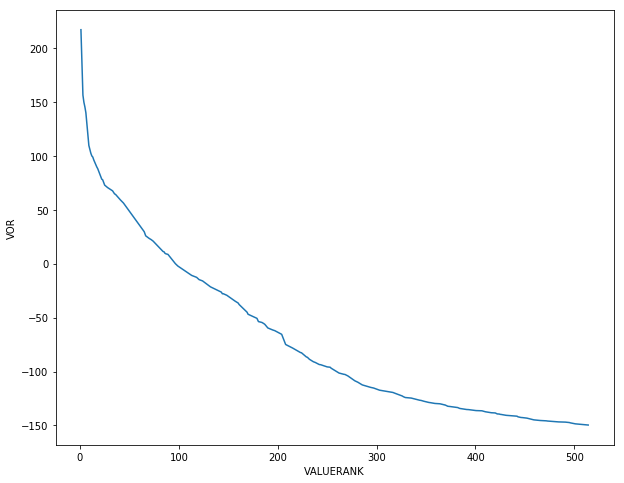

In [42]:
fig = plt.figure(figsize=(10,8))

sns.lineplot(x='VALUERANK', y='VOR', data=df[df['POS'] == 'RB'])

plt.show()

In [49]:
positions = list(set(df.POS.values))
positions

['RB', 'WR', 'QB', 'TE']

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


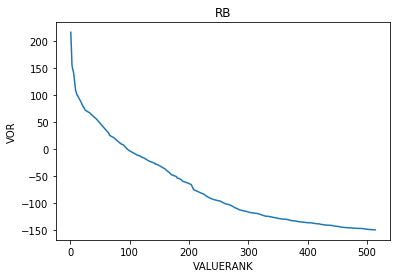

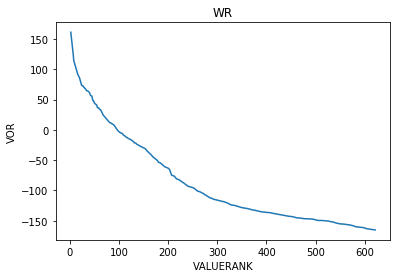

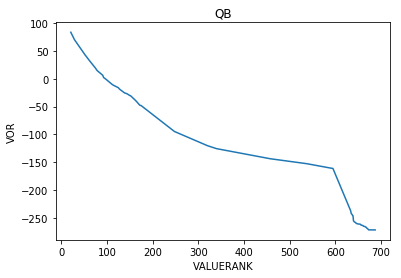

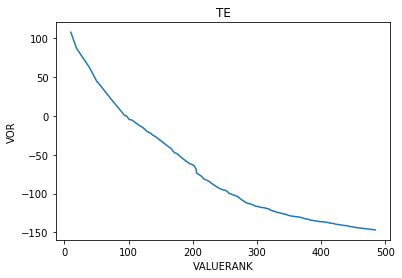

In [57]:
for p in positions:
    sns.lineplot(x='VALUERANK', y='VOR', data=df[df['POS'] == p])
    plt.title(p)
    plt.show()

In [62]:
adp_df = make_adp_df()
adp_df.head()

Output after reading the html:

    Rank             Player Team (Bye)  POS  ESPN  MFL  RTSports  Fantrax  AVG
0     1  Christian McCaffrey CAR (13)  RB1   1.0  NaN       1.0      1.0  1.0
1     2       Saquon Barkley NYG (11)  RB2   2.0  NaN       2.0      2.0  2.0
2     3      Ezekiel Elliott DAL (10)  RB3   3.0  NaN       3.0      4.0  3.3
3     4           Dalvin Cook MIN (7)  RB4   4.0  NaN       5.0      5.0  4.7
4     5         Michael Thomas NO (6)  WR1   6.0  NaN       6.0      3.0  5.0 

Output after filtering:

               Player Team (Bye)  POS  AVG
0  Christian McCaffrey CAR (13)  RB1  1.0
1       Saquon Barkley NYG (11)  RB2  2.0
2      Ezekiel Elliott DAL (10)  RB3  3.3
3           Dalvin Cook MIN (7)  RB4  4.7
4         Michael Thomas NO (6)  WR1  5.0 

Final output:

                 PLAYER POS  AVG
0  Christian McCaffrey  RB  1.0
1       Saquon Barkley  RB  2.0
2      Ezekiel Elliott  RB  3.3
3          Dalvin Cook  RB  4.7
4       Michael Thomas  WR  5.0


,PLAYER,POS,AVG
0,Christian McCaffrey,RB,1.0
1,Saquon Barkley,RB,2.0
2,Ezekiel Elliott,RB,3.3
3,Dalvin Cook,RB,4.7
4,Michael Thomas,WR,5.0


In [63]:
adp_df['ADPRANK'] = adp_df['AVG'].rank(method='first')

adp_df.head()

,PLAYER,POS,AVG,ADPRANK
0,Christian McCaffrey,RB,1.0,1.0
1,Saquon Barkley,RB,2.0,2.0
2,Ezekiel Elliott,RB,3.3,3.0
3,Dalvin Cook,RB,4.7,4.0
4,Michael Thomas,WR,5.0,5.0


Merge dataframes

In [65]:
df = df.merge(adp_df, how='left', on=['PLAYER', 'POS'])

df.head()

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK
0,Christian McCaffrey,RB,366.5,216.9,1.0,1.0,1.0
1,Michael Thomas,WR,326.3,161.2,2.0,5.0,5.0
2,Saquon Barkley,RB,305.9,156.3,3.0,2.0,2.0
3,Ezekiel Elliott,RB,299.2,149.6,4.0,3.3,3.0
4,Alvin Kamara,RB,294.9,145.3,5.0,5.0,6.0


In [66]:
df.head(100)

,PLAYER,POS,FPTS,VOR,VALUERANK,AVG,ADPRANK
0,Christian McCaffrey,RB,366.5,216.9,1.0,1.0,1.0
1,Michael Thomas,WR,326.3,161.2,2.0,5.0,5.0
2,Saquon Barkley,RB,305.9,156.3,3.0,2.0,2.0
3,Ezekiel Elliott,RB,299.2,149.6,4.0,3.3,3.0
4,Alvin Kamara,RB,294.9,145.3,5.0,5.0,6.0
5,Dalvin Cook,RB,289.5,139.9,6.0,4.7,4.0
6,Davante Adams,WR,289.3,124.2,7.0,11.0,8.0
7,Julio Jones,WR,279.7,114.6,8.0,16.3,18.0
8,Derrick Henry,RB,259.2,109.6,9.0,7.7,7.0
9,Travis Kelce,TE,254.2,107.5,10.0,17.7,19.0
